In this exercise, you will code a neural network for classifying audio segements for five different syllables: 'a' (as in 'bar'), 'e' (as in 'bed'), 'i' (as in 'big'), 'o' (as in 'shop'), 'u' (as in 'look').

Download and unzip the data from [here](https://drive.google.com/open?id=1mzoJ-l99yduGDs4we3iL1D3qssHFjbne) and listen to the different .wav files. 

As features, we will use the spectrograms extracted from each wav file, that look something like the image [here](https://drive.google.com/open?id=19vXRpeeNHt2wv0e9o3KvEKYjxQzqa1WK). The spectrogram is acquired by applying a Fourier transform on overlapping 25ms windows on the audio. The x-axis is the time, and the y-axis is the frequency.

To upload the data into this notebook, follow the instructions of the **"Prepare the data"**-section below.

To visualize more spectrograms, use the **"Visualize spectrogram"** cell below.

Each wav file is one second, and the corresponding spectrogram is of shape \[97, 201] (97 time steps, 201 frequencies). You don't have to know much about the Fourier transform and audio/signal processing in order to classify audio segments with a neural network. From now on, we can just assume every audio segment is represented by a sequence of 97 time steps, where at each time step we have 201 features, regardless of their meaning. 

Our model will use a simple recurrent layer / LSTM layer. To compute the logits, we will apply an additional fully connected layer on the state of the last time step. On the logits we will apply `softmax` and compute the `cross entropy loss`. 

We will be implementing our custom RNN cells, which are fed in a custom RNN Layer, already implemented below.

## Initial imports

In [1]:
import os
import torch
import numpy as np
import typing
import numpy as np
from matplotlib import pyplot as plt

print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.2.0+cu121


## Prepare the data

1. Download the data and load it into the memory. Follow either the steps for your local python/jupyter notebook installation or the steps for google colab.

### Steps for your local jupyter notebook

If you are using jupyter notebook on your local machine, download the vowels.zip file, extract it, and set the path of the 'basefolder' variable to the vowels-directory. E.g. basefolder = "home/user/DeepLearningPraktikum/Exercise4/vowels/"

In [2]:
basefolder = "data/vowels" #TODO Where you extracted the data, leave empty in Colab

### Steps for google colab

If you are using google colab there are a few possibilities for you to upload the vowels-data into the colab notebook.


#### Possibility 1

Use the code in the cell below to load the vowels.zip file into your colab-notebook.

In [3]:
#!wget -O vowels.zip "https://drive.google.com/uc?export=download&id=1mzoJ-l99yduGDs4we3iL1D3qssHFjbne" && unzip vowels.zip -d vowels && rm vowels.zip
#
#basefolder = "vowels"

#### Possibility 2
1. Upload the extracted vowels folder to your google drive.
2. Mount your drive to collaboratory by using the cell below
3. Now, set the basefolder-variable to the path in your drive where the vowels-folder is located. E.g. basefolder = "/content/drive/MyDrive/vowels" or something like basefolder = "/content/vowels". One way to find out the path to the vowel-folder is by having a look at the files in the panel on the left side of your notebook.

In [4]:
## Mount your google drive 
#from google.colab import drive
#drive.mount('/content/drive')

## Set the basefolder-path
#basefolder = "" #TODO Where your data is located in your drive, leave empty if you are using your local jupyter notebook or already did option 1.

## Start Exercises

2. Get acquainted to the data by listening to the audio files, looking at the spectrogram depicted below and by investigating the code for data preparation below

## Visualize spectrogram

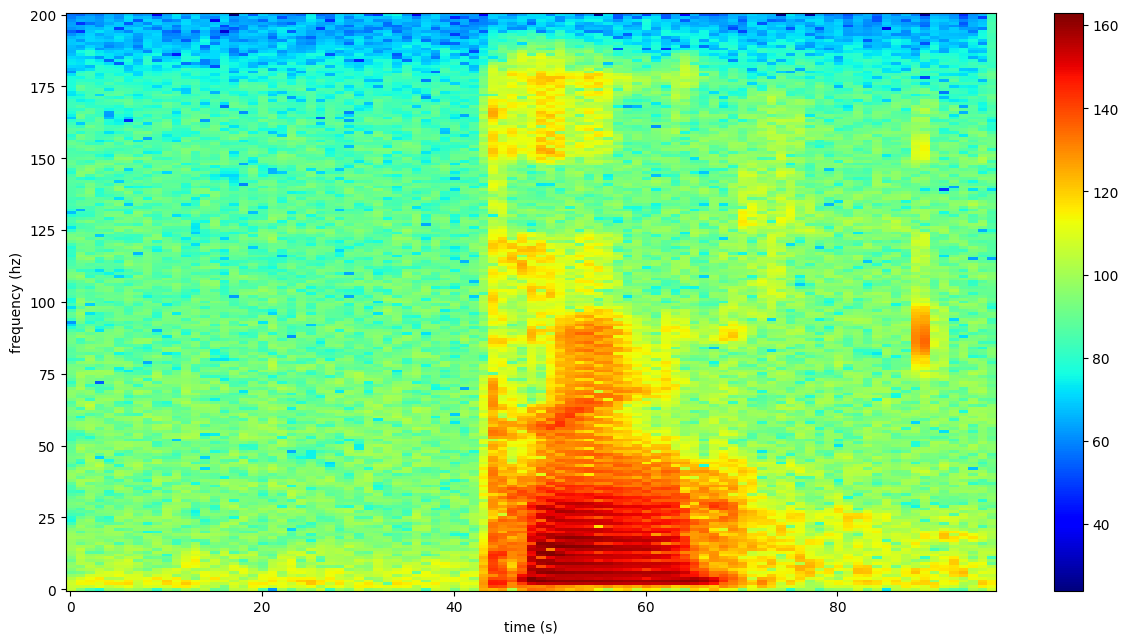

In [5]:
import os
import torch
import numpy as np
import typing
from matplotlib import pyplot as plt
# basefolder = "~/vowels/"

audio = 'a/8.npy'
mag = np.load(os.path.join(basefolder, audio))
mag = 20.*np.log10(np.abs(mag)/10e-6) # amplitude to decibel

plt.figure(figsize=(15, 7.5))
plt.imshow(np.transpose(mag), origin="lower", aspect="auto", cmap='jet', interpolation="none")
plt.colorbar()

plt.xlabel("time (s)")
plt.ylabel("frequency (hz)")

plt.show()

## Loading the data

In [6]:
# Loading the data before training the neural network

import os
import torch
import numpy as np
import typing


"""
def load_folder(fold):
    features = []
    for fl in os.listdir(basefolder + fold):
        if fl.endswith('.npy'):
            features.append(np.load(basefolder + fold + '/' + fl))
    return np.stack(features)
"""

def load_folder(fold):
    features = []
    for fl in os.listdir(os.path.join(basefolder, fold)):
        if fl.endswith('.npy'):
            features.append(np.load(os.path.join(basefolder, fold, fl)))
    return np.stack(features)

train_features = []
train_labels = []
test_features = [] 
test_labels = []
for i, vowel in enumerate('aeiou'):
    features = load_folder(vowel)
    nexamples = len(features)
    labels = [i] * nexamples
    l = int(0.8 * nexamples)
    train_features.append(features[:l]) 
    train_labels.append(labels[:l])
    test_features.append(features[l:]) 
    test_labels.append(labels[l:])
X_train = np.concatenate(train_features)
y_train = np.concatenate(train_labels)
X_test = np.concatenate(test_features)
y_test = np.concatenate(test_labels)

##### torch
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)
  
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([187, 97, 201]) torch.Size([187]) torch.Size([48, 97, 201]) torch.Size([48])


3. Use the variables `X_train`, `y_train`, `X_test` and `y_test` to create datasets (`torch.utils.data.TensorDataset`) and dataloaders. Use a batch_size of 32 for the dataloaders.

In [7]:
# 3. Use the variables `X_train`, `y_train`, `X_test` and `y_test` to create datasets (`torch.utils.data.TensorDataset`) and dataloaders. Use a batch_size of 32 for the dataloaders.

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

4. Have a look at the implementation of the MyRNNLayer, which is used to wrap different types of RNNCells in a recurrent manner. The RNNLayer can be initialised either to output a sequence, i.e., to forward one output for each element of the sequence to the next layer, or to forward only one output at the last element of the sequence to the next layer. This has no effect on the calculation of the hidden state or cell state, but only affects, which values are used as an output. 

In [8]:
class MyRNNLayer(torch.nn.Module):
    def __init__(
        self, 
        rnn_cell: torch.nn.Module, 
        return_sequence=False
    ):
        r"""RNN Constructor.

        Args:
            rnn_cell: the cell of the rnn defining how inputs are processed 
            return_sequence: flag controlling whether the ouput is a sequence or single elemnt
        """
        super(MyRNNLayer, self).__init__()
        self.return_sequence = return_sequence
        self.rnn_cell = rnn_cell
    
    def forward(
        self,
        x: torch.Tensor
    ) -> torch.Tensor:
        r"""Processes the incoming sequence according to the RNNcell.

        Args:
            x: pytorch tensor containing a sequence features 

        Returns:
            torch.Tensor: output of the RNN, either 2D (no sequence) or 3D (sequence) 
        """
        cell = self.rnn_cell.zero_hidden()
        hidden_states = torch.zeros(x.shape[0], x.shape[1], self.rnn_cell.hidden_features, device=x.device)
        for i in range(x.shape[1]):
            hidden, cell  = self.rnn_cell(x[:,i,:], cell)
            hidden_states[:,i,:] = hidden
        if self.return_sequence:
            return hidden_states
        else:
            return hidden
    


5. Implement the MinimalRNNCell, i.e., the methods `__init__`, initialising all parameters of the cell (you can use the function `torch.nn.init.kaiming_uniform_(self.bias)`), the `zero_hidden` method, which initialises the hidden state of the cell as zero and the `forward` method. The `forward` method processes the transition for a single step in a sequence of intputs. It takes the $i$th input from the previous layer $x_i$ (e.g. input layer) and the hidden state of the previous step $c_{i-1}$, and computes the state and output for the current step $c_i, h_i$. For a simple recurrent network, the output and the state of of a given time step are the same. The transition for a single time step is given by: $c_i = h_i = \text{tanh}(x_i W_x + h_{i-1} W_h + b)$.

In [9]:
class MinimalRNNCell(torch.nn.Module):
    def __init__(
        self, 
        in_features: int, 
        hidden_features:int,
        device:str
    ):
        r"""Simple RNN Cell Constructor.
        
        Args:
            in_features: number of input features (in each sequence) 
            hidden_features: number of features in the hidden state
        """
        super().__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.device = device
        
        # c_i = h_i = tanh(x_i W_x + h_(i-1) W_h + b)
        self.W_x = torch.nn.Parameter(torch.randn(in_features, hidden_features, device=device))
        self.W_h = torch.nn.Parameter(torch.randn(hidden_features, hidden_features, device=device))
        self.b = torch.nn.Parameter(torch.randn(hidden_features, device=device))
        torch.nn.init.kaiming_uniform_(self.W_x)
        torch.nn.init.kaiming_uniform_(self.W_h)
                
    def forward(
        self, 
        x: torch.Tensor, 
        c: torch.Tensor
    )-> typing.Tuple[torch.Tensor, torch.Tensor]:
        r"""Processes the incoming input and previous cell state for one step in the sequence.

        Args:
            x: pytorch tensor containing an element of the input sequence
            c: pytorch tensor containing the previous cell state

        Returns:
            (torch.Tensor, torch.Tensor): output to the next layer (vert), and cell state (for next sequence elemnt) 
        """
        
        # c_i = h_i = tanh(x_i W_x + h_(i-1) W_h + b)
        hidden = torch.tanh(x @ self.W_x + c @ self.W_h + self.b)
        return hidden, hidden
        
    def zero_hidden(
        self
    )-> torch.Tensor:
        r"""Initialises cell state with zeros. Assign the hidden state to the model device (necessary when using GPU)

        Returns:
            torch.Tensor: cell state initialised with zeros  
        """

        # shape: (1, hidden_features) 
        # 1 will be broadcasted to the batch size
        return torch.zeros(1, self.hidden_features, device=self.device)

6. Implement your own RNN model below. The model should consist of one RNN layer with a minimal RNN cell with a hidden layer size of 128, followed by a dense classification layer with 5 outputs according to the 5 classes. Use a `torch.nn.Linear` layer as a classification layer.

In [10]:
# 6. Implement your own RNN model below. The model should consist of one RNN layer with a minimal RNN cell with a hidden layer size of 128, followed by a dense classification layer with 5 outputs according to the 5 classes. Use a `torch.nn.Linear` layer as a classification layer.

class MyRNN(torch.nn.Module):
    def __init__(
        self, 
        in_size:int, 
        hidden_size:int, 
        output_size:int,
        device:str
    ):
        super().__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device

        self.rnn1 = MyRNNLayer(
            MinimalRNNCell(in_size, hidden_size, device),
            return_sequence=False # we only need the last hidden state
        )

        self.dense = torch.nn.Linear(hidden_size, output_size, device=device)
    
    def forward(
        self, 
        x # (batch, seq, features)
    ):
        x = self.rnn1(x) # (batch, hidden)
        x = self.dense(x) # (batch, output)
        return x

Below are suggested solutions for the implementation of the routine for training and evaluation, and all necessary functions following yesterday's examples. The functions should be ready to run.   

In [11]:
def single_model_step(
    model: torch.nn.Module, 
    optimizer: torch.optim.Optimizer,
    loss_function: typing.Callable,
    training: bool,
    X: torch.Tensor, 
    y: torch.Tensor,
    device: str
) -> torch.Tensor:
    r"""Single model training/evaluation step.

    Args:
        model: pytorch model to be trained
        optimizer: optimizer wrapping pytorch model
        loss_function: loss function
        training: flag controlling whether this is a training
            or an evaluation step
        X: pytorch tensor containing features
        y: pytorch tensor containing labels
        device: device to where model is located
        
    Returns:
        torch.Tensor: loss at current step
    """
    pred = model(X.to(device))
    loss = loss_function(pred, y.to(device))
    if training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.cpu().item()

def inference_model(
    model: torch.nn.Module, 
    loader: torch.utils.data.DataLoader,
    num_classes,
    device: str
):
    r"""Evaluate model on dataloader.
    
    Iterates over loader until it is exhausted 
    and stores the model output (logits) and labels
    in tensors.
    
    Args:
        model: model to be evaluated
        loader: dataloader containing data to evaluate model on
        device: string denoting device on which to run evaluation
        
    Returns:
        torch.Tensor: model outputs (logits)
        torch.Tensor: ground truth labels
    """
    model.eval()
    logits = torch.zeros((len(loader.dataset), num_classes), device=device)
    labels = torch.zeros((len(loader.dataset)), device=device)
    batch_size = loader.batch_size
    with torch.no_grad():
        for index, (X, y) in enumerate(loader):
            logits[index*batch_size:(index+1)*batch_size, :] = model(X.to(device))
            labels[index*batch_size:(index+1)*batch_size] = y
    return logits, labels

#logits, labels = inference_model(model, test_loader, 5, device)
def get_accuracy(labels, logits):
    r"""Compute accuracy.
    
    Args:
        labels: ground truth labels
        logits: model predictions
    
    Returns:
        torch.Tensor: single accuracy value
    """
    prediction_indices = torch.argmax(logits, axis=-1)
    correct_predictions = labels == prediction_indices
    accuracy = correct_predictions.sum() / len(correct_predictions)
    return accuracy.item()





def train_and_evaluate(
    model: torch.nn.Module, 
    loss_function: typing.Callable, 
    optimizer: torch.optim.Optimizer, 
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    num_classes: int,
    epochs: int,
    device: str,
    verbose: bool,
):
    r"""Run training and evaluation.
    
    Args:
        model: pytorch model to be trained
        loss_function: loss function
        optimizer: optimizer wrapping pytorch model
        train_loader: dataloader containing training data
        test_loader: dataloader containing training data
        num_classes: number of classes for the classification task
        epochs: number of epochs for which to train model
        device: device to where model is located
        verbose: flag controlling whether to print information
        
    Returns:
        torch.Tensor: accuracy on test set after last epoch
    """
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for train_steps, (X, y) in enumerate(train_loader):
            X.to(device)
            y.to(device)
            train_loss += single_model_step(
                model=model, 
                loss_function=loss_function, 
                optimizer=optimizer, 
                training=True,
                X=X, 
                y=y,
                device=device
            )
        train_loss /= (train_steps + 1)
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for test_steps, (X, y) in enumerate(test_loader):
                test_loss += single_model_step(
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optimizer, 
                    training=False,
                    X=X, 
                    y=y,
                    device=device
                )
        test_loss /= test_steps
        
        logits, labels = inference_model(
                model=model, 
                loader=test_loader,
                num_classes=num_classes,
                device=device
            )
        accuracy = get_accuracy(
            labels=labels,
            logits=logits
        )
        
        if verbose:
            print(f"\n---------- EPOCH {epoch + 1} ------------")
            print(f"Average Train Loss: {train_loss}")
            print(f"Average Test Loss: {test_loss}")
            
        
            print(f"Test Accuracy: {accuracy}")
    return accuracy

7. Instantiate your own RNN model, then run the train_and_evaluate function implemented above using a cross entropy loss function, an Adam optimiser with `0.001` learning rate for 40 epochs. Finally, create a confusion matrix, a table that lists how often samples of the classes were predicted to be within any of the (other) classes. You can use an `sklearn` implementation. Note: We recommend using the CPU for training in today's exercise sheet as the models are fast to train with CPU as well and you do not risk running out of GPU resources.

In [12]:
torch.manual_seed = 42

# Instantiate model and run training and evaluation
model = MyRNN(in_size=X_train.shape[-1], hidden_size=128, output_size=5, device=device).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_and_evaluate(
    model=model, 
    loss_function=loss_function, 
    optimizer=optimizer, 
    train_loader=train_loader,
    test_loader=test_loader,
    num_classes=5,
    epochs=40,
    device=device,
    verbose=True,
)


---------- EPOCH 1 ------------
Average Train Loss: 1.7148091991742451
Average Test Loss: 3.1995604038238525
Test Accuracy: 0.25

---------- EPOCH 2 ------------
Average Train Loss: 1.5320789813995361
Average Test Loss: 3.1756497621536255
Test Accuracy: 0.2708333432674408

---------- EPOCH 3 ------------
Average Train Loss: 1.4272140463193257
Average Test Loss: 3.2074626684188843
Test Accuracy: 0.2916666865348816

---------- EPOCH 4 ------------
Average Train Loss: 1.3459360202153523
Average Test Loss: 3.2005393505096436
Test Accuracy: 0.2083333432674408

---------- EPOCH 5 ------------
Average Train Loss: 1.272958219051361
Average Test Loss: 3.177450180053711
Test Accuracy: 0.2291666716337204

---------- EPOCH 6 ------------
Average Train Loss: 1.1995014349619548
Average Test Loss: 3.1835556030273438
Test Accuracy: 0.2916666865348816

---------- EPOCH 7 ------------
Average Train Loss: 1.1381579637527466
Average Test Loss: 3.2108612060546875
Test Accuracy: 0.25

---------- EPOCH 8 --

0.375

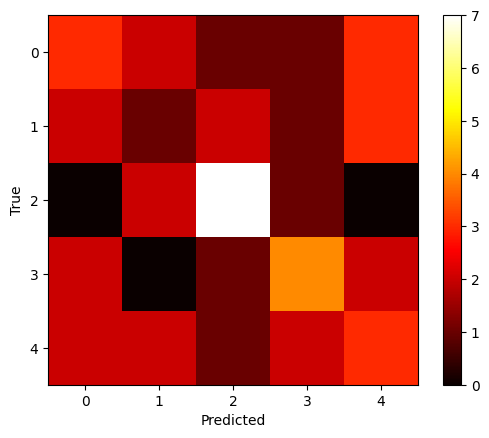

In [13]:
# Finally, create a confusion matrix, a table that lists how often samples of the classes were predicted to be within any of the (other) classes. You can use an `sklearn` implementation.

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

logits, labels = inference_model(model, test_loader, 5, device)
prediction_indices = torch.argmax(logits, axis=-1)
cm = confusion_matrix(labels.cpu(), prediction_indices.cpu())

plt.imshow(cm, cmap='hot', interpolation='nearest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

## Advanced Model Architecture

8. Complete the the `LSTMCell` class below. Now, use this recurrent cell with a hidden layer size of 128 instead of the previous `MinimalRNNCell` for a new RNN class. The `forward` method shall return the new cell output and the new cell state(s). Train your model for 50 epochs with an Adam optimiser and learning rate equal to 0.01. The implementation of `MyRNN2` should be very similar to `myRNN`.

In [14]:
class LSTMCell(torch.nn.Module):
    def __init__(
        self, 
        in_features: int, 
        hidden_features: int,
        device:str
    ):
        r"""LSTM Cell Constructor.
        
        Args:
            in_features: number of input features (in each sequence) 
            hidden_features: number of features in the hidden and cell state, respectively
        """
        super().__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.device = device
        # Initialise Parameters
        self.W_f = torch.nn.Parameter(torch.randn(in_features, hidden_features, device=device))
        self.U_f = torch.nn.Parameter(torch.randn(hidden_features, hidden_features, device=device))
        self.b_f = torch.nn.Parameter(torch.randn(hidden_features, device=device))
        torch.nn.init.kaiming_uniform_(self.W_f)
        torch.nn.init.kaiming_uniform_(self.U_f)

        self.W_i = torch.nn.Parameter(torch.randn(in_features, hidden_features, device=device))
        self.U_i = torch.nn.Parameter(torch.randn(hidden_features, hidden_features, device=device))
        self.b_i = torch.nn.Parameter(torch.randn(hidden_features, device=device))
        torch.nn.init.kaiming_uniform_(self.W_i)
        torch.nn.init.kaiming_uniform_(self.U_i)

        self.W_o = torch.nn.Parameter(torch.randn(in_features, hidden_features, device=device))
        self.U_o = torch.nn.Parameter(torch.randn(hidden_features, hidden_features, device=device))
        self.b_o = torch.nn.Parameter(torch.randn(hidden_features, device=device))
        torch.nn.init.kaiming_uniform_(self.W_o)
        torch.nn.init.kaiming_uniform_(self.U_o)

        self.W_c = torch.nn.Parameter(torch.randn(in_features, hidden_features, device=device))
        self.U_c = torch.nn.Parameter(torch.randn(hidden_features, hidden_features, device=device))
        self.b_c = torch.nn.Parameter(torch.randn(hidden_features, device=device))
        torch.nn.init.kaiming_uniform_(self.W_c)
        torch.nn.init.kaiming_uniform_(self.U_c)


    def forward(
        self, 
        x: torch.Tensor, 
        c: typing.Tuple[torch.Tensor, torch.Tensor]
    )-> typing.Tuple[torch.Tensor, typing.Tuple[torch.Tensor, torch.Tensor]]:
        r"""Processes the incoming input and previous cell state for one step in the sequence.

        Args:
            x: pytorch tensor containing an element of the input sequence
            c: tuple of pytorch tensors containing the previous hidden and cell state

        Returns:
            (torch.Tensor, (torch.Tensor, torch.Tensor)): \
            output to the next layer (vert), and hidden and cell state (for next sequence elemnt) 
        """
        # Define forward
        # f_t = sigmoid(x_t @ W_f + h_(t-1) @ U_f + b_f)
        # i_t = sigmoid(x_t @ W_i + h_(t-1) @ U_i + b_i)
        # o_t = sigmoid(x_t @ W_o + h_(t-1) @ U_o + b_o)
        # ctilde_t = tanh(x_t @ W_c + h_(t-1) @ U_c + b_c)

        # c_t = f_t * c_(t-1) + i_t * ctilde_t
        # h_t = o_t * tanh(c_t)

        hp, cp = c
        f = torch.sigmoid(x @ self.W_f + hp @ self.U_f + self.b_f)
        i = torch.sigmoid(x @ self.W_i + hp @ self.U_i + self.b_i)
        o = torch.sigmoid(x @ self.W_o + hp @ self.U_o + self.b_o)
        ctilde = torch.tanh(x @ self.W_c + hp @ self.U_c + self.b_c)
        c = f * cp + i * ctilde
        h = o * torch.tanh(c)

        return h, (h, c)
        
    def zero_hidden(
        self, 
    )-> typing.Tuple[torch.Tensor, torch.Tensor]:
        r"""Initialises cell state with zeros. Assign the hidden state to the model device (necessary when using GPU)

        Returns:
            (torch.Tensor, torch.Tensor): cell and hidden state initialised with zeros  
        """
        # TODO Return initial hidden state with zeros, consider the necessary shape (remember broadcasting)!
        
        # shape: (1, hidden_features)
        # 1 will be broadcasted to the batch size

        return torch.zeros(1, self.hidden_features, device=self.device), torch.zeros(1, self.hidden_features, device=self.device)

In [15]:
class MyRNN2(torch.nn.Module):
    def __init__(
        self, 
        in_size:int, 
        hidden_size:int, 
        output_size:int,
        device:str
    ):
        super().__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device
        # TODO: Define Cells and Layers 
        self.rnn1 = MyRNNLayer(
            LSTMCell(in_size, hidden_size, device),
            return_sequence=False # we only need the last hidden state
        )

        self.dense = torch.nn.Linear(hidden_size, output_size, device=device)
            
    def forward(
        self, 
        x
    ):
        x = self.rnn1(x)
        x = self.dense(x)
        return x

In [16]:
torch.manual_seed = 42

model2 = MyRNN2(in_size=X_train.shape[-1], hidden_size=128, output_size=5, device=device).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

train_and_evaluate(
    model=model2, 
    loss_function=loss_function, 
    optimizer=optimizer, 
    train_loader=train_loader,
    test_loader=test_loader,
    num_classes=5,
    epochs=50,
    device=device,
    verbose=True,
)


---------- EPOCH 1 ------------
Average Train Loss: 1.594969391822815
Average Test Loss: 3.198975086212158
Test Accuracy: 0.2916666865348816

---------- EPOCH 2 ------------
Average Train Loss: 1.4697988430658977
Average Test Loss: 3.125299572944641
Test Accuracy: 0.375

---------- EPOCH 3 ------------
Average Train Loss: 1.3757662177085876
Average Test Loss: 3.1012003421783447
Test Accuracy: 0.375

---------- EPOCH 4 ------------
Average Train Loss: 1.2842280467351277
Average Test Loss: 3.0756176710128784
Test Accuracy: 0.375

---------- EPOCH 5 ------------
Average Train Loss: 1.1781304478645325
Average Test Loss: 2.973311424255371
Test Accuracy: 0.3541666865348816

---------- EPOCH 6 ------------
Average Train Loss: 1.0570008158683777
Average Test Loss: 2.8811835050582886
Test Accuracy: 0.3125

---------- EPOCH 7 ------------
Average Train Loss: 0.9238607386747996
Average Test Loss: 2.7223767042160034
Test Accuracy: 0.4375

---------- EPOCH 8 ------------
Average Train Loss: 0.7880

0.6875

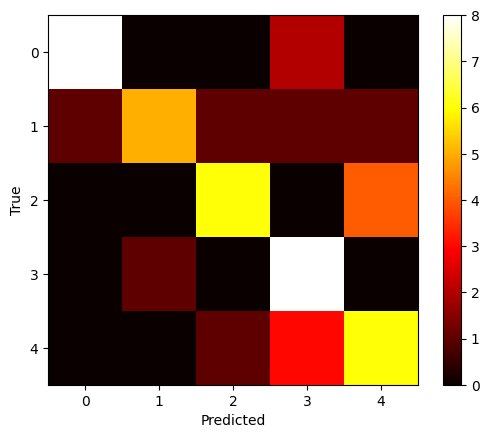

In [17]:

logits, labels = inference_model(model2, test_loader, 5, device)
prediction_indices = torch.argmax(logits, axis=-1)
cm = confusion_matrix(labels.cpu(), prediction_indices.cpu())

plt.imshow(cm, cmap='hot', interpolation='nearest')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

9. Add more recurrent layers. The second recurrent layer takes as input the output sequence from the first recurrent layer, and so on. That is, make sure each recurrent layer returns the full sequence instead of only the last output. Train your network as in the previous exercise

In [18]:
# 9. Add more recurrent layers. The second recurrent layer takes as input the output sequence from the first recurrent layer, and so on. That is, make sure each recurrent layer returns the full sequence instead of only the last output. Train your network as in the previous exercise

class MyRNN3(torch.nn.Module):
    def __init__(
        self, 
        in_size:int, 
        hidden_size:int, 
        output_size:int,
        num_rnn_layers:int,
        device:str
    ):
        super().__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device

        self.layers = torch.nn.ModuleList()
        self.layers.append(MyRNNLayer(
            LSTMCell(in_size, hidden_size, device),
            return_sequence=True
        ))
        for _ in range(num_rnn_layers - 2):
            self.layers.append(MyRNNLayer(
                LSTMCell(hidden_size, hidden_size, device),
                return_sequence=True
            ))
        self.layers.append(MyRNNLayer(
            LSTMCell(hidden_size, hidden_size, device),
            return_sequence=False
        ))

        self.dense = torch.nn.Linear(hidden_size, output_size, device=device)

    def forward(
        self, 
        x
    ):
        for layer in self.layers:
            x = layer(x)
        x = self.dense(x)
        return x

In [19]:
torch.manual_seed = 42
model3 = MyRNN3(in_size=X_train.shape[-1], hidden_size=128, output_size=5, num_rnn_layers=3, device=device).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

train_and_evaluate(
    model=model3, 
    loss_function=loss_function, 
    optimizer=optimizer, 
    train_loader=train_loader,
    test_loader=test_loader,
    num_classes=5,
    epochs=50,
    device=device,
    verbose=True,
)


---------- EPOCH 1 ------------
Average Train Loss: 1.6037152608235676
Average Test Loss: 3.1683684587478638
Test Accuracy: 0.2916666865348816

---------- EPOCH 2 ------------
Average Train Loss: 1.4888911445935566
Average Test Loss: 3.0561954975128174
Test Accuracy: 0.4583333432674408

---------- EPOCH 3 ------------
Average Train Loss: 1.3074000477790833
Average Test Loss: 2.7993154525756836
Test Accuracy: 0.5

---------- EPOCH 4 ------------
Average Train Loss: 1.010355403025945
Average Test Loss: 2.180588126182556
Test Accuracy: 0.7083333730697632

---------- EPOCH 5 ------------
Average Train Loss: 0.7262754539648691
Average Test Loss: 1.9369823932647705
Test Accuracy: 0.7083333730697632

---------- EPOCH 6 ------------
Average Train Loss: 0.5484749128421148
Average Test Loss: 1.7064452171325684
Test Accuracy: 0.7291666865348816

---------- EPOCH 7 ------------
Average Train Loss: 0.3477981189886729
Average Test Loss: 1.1171274781227112
Test Accuracy: 0.8125

---------- EPOCH 8 -

0.8958333730697632

10. Hyperparameters are all parameters of your model that you define a priori and that will not be tuned/learned during training. Examples are: learning rate, batch size, optimizer, size of the hidden layer or number of hidden layers. Explore the hyperparameter space to find a better performance. You can run for instance a grid search with wisely chosen hyperparameters and hyperparameters. Can you get a test accuracy beyond 85%?

In [20]:
# previous run was at 89.58% accuracy
# hyperparameters:
# learning rate: 0.001
# batch size: 32
# optimizer: Adam
# hidden size: 128
# number of layers: 3 lstm + 1 dense
# epochs: 50 (stable accuracy since epoch 39)

# further exploration didn't yield better results (except statistical noise up to ~91% that doesn's stick more than one epoch)